# 0 - Repository download and data preparation

In [ ]:
#! /usr/bin/python3
# -*- coding: utf-8 -*-
# Authors: Álvaro García Mosqueda & Inés Martínez Fernández
# Last version: 21-11-2025
# Movie reviews classifier

#Download repository from github with the dataset
import subprocess
import os

# Clonar repo (silenciado)
subprocess.run(
    ["git", "clone", "https://github.com/cafeolee/movie_reviews_dataset.git"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)

os.chdir("movie_reviews_dataset")

# Descomprimir archivos (silenciado)
for zip_file, folder in [("train.zip", "train"), ("dev.zip", "dev"), ("test_blind.zip", "test_blind")]:
    subprocess.run(
        ["unzip", "-o", zip_file, "-d", folder],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )

# Definir rutas
train_path = "train/train/"
dev_path   = "dev/dev/"
blind_path = "test_blind/test_blind/"

Cloning into 'movie_reviews_dataset'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), 3.59 MiB | 20.91 MiB/s, done.
/content/movie_reviews_dataset
Archive:  train.zip
   creating: train/train/
   creating: train/train/neg/
  inflating: train/train/neg/cv002_17424.txt  
  inflating: train/train/neg/cv003_12683.txt  
  inflating: train/train/neg/cv004_12641.txt  
  inflating: train/train/neg/cv007_4992.txt  
  inflating: train/train/neg/cv009_29417.txt  
  inflating: train/train/neg/cv011_13044.txt  
  inflating: train/train/neg/cv012_29411.txt  
  inflating: train/train/neg/cv014_15600.txt  
  inflating: train/train/neg/cv015_29356.txt  
  inflating: train/train/neg/cv017_23487.txt  
  inflating: train/train/neg/cv018_21672.txt  
  inflating: train/train/neg/cv019_16117.txt  
  inflating: train/train/neg/c

In [ ]:
#Define paths
train_path = "train/train/"
dev_path   = "dev/dev/"
blind_path = "test_blind/test_blind/"

# 1 - Libraries

In [2]:
import datetime
import pandas as pd
import os
import re
import nltk
from nltk import word_tokenize #Tokenizer from nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords') #List of stopwords
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #Feature extraction
from sklearn.naive_bayes import MultinomialNB #naive bayes (multinomial)
from sklearn.tree import DecisionTreeClassifier #decision tree
from sklearn.ensemble import RandomForestClassifier #random forest
from sklearn.neighbors import KNeighborsClassifier #knn (euclidean)
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # to evaluate the performance of the model
import matplotlib.pyplot as plt
import numpy as np
import random
!pip install contractions
import contractions
from sklearn.manifold import TSNE
import nltk.classify.util
import seaborn as sns
from google.colab import files
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.6 MB/s eta 0:00:00


# 2 - Functions

In [3]:
def data_load(dir_path): #This function loads (open and read) the archives (.txt) we want to work with
    corpus = []
    for filename in os.listdir(dir_path):
      if filename.endswith('.txt'):
        file_path = os.path.join(dir_path, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
          text = f.read()
          corpus.append(text)
    return corpus

def cleaner(corpus): #This function clear the raw text data from a lot of non-alphanumerical characters, so it is easier to analyze
  corpus_cleaned = []
  if type(corpus) == list:
    for text in corpus:
      text = contractions.fix(text)
      text = re.sub(r"\'s\b", "", text)
      text = re.sub(r"[–—−]", "-", text)
      text = re.sub(r"[^a-zA-Z0-9\- ]", "", text)
      text = re.sub(r" +", " ", text)
      text = text.lower()
      corpus_cleaned.append(text)
  return corpus_cleaned

def tokenizer(corpus):
  corpus_tokenized = []
  en_stop_words = set(stopwords.words('english'))
  for text in corpus:
      tokens = word_tokenize(text)
      filtered_tokens = [word for word in tokens if word not in en_stop_words]
      corpus_tokenized.append(filtered_tokens)
  return corpus_tokenized

def get_wordnet_pos(tag): #Allow us to transform NLTK pos tags into WordNet pos tags
  pos_map = {
    'J': wordnet.ADJ,
    'V': wordnet.VERB,
    'N': wordnet.NOUN,
    'R': wordnet.ADV
  }
  return pos_map.get(tag[0], wordnet.NOUN)

def lemmatizer(corpus):
  wln = WordNetLemmatizer()
  corpus_lemmatized = []
  for element in corpus:
    tagged = pos_tag(element) #We need to tag the tokens so that the lemmatizer works correctly
    lemma = [wln.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged]
    corpus_lemmatized.append(" ".join(lemma))
  return corpus_lemmatized

def corpus_builder(list_pos, list_neg):
  list_pos_labeled = []
  list_neg_labeled = []
  for element in list_pos:
    list_pos_labeled.append((element, 'positive'))
  for element in list_neg:
    list_neg_labeled.append((element, 'negative'))
  corpus_unified = list_pos_labeled + list_neg_labeled
  random.seed(42)
  random.shuffle(corpus_unified)
  corpus_text = [text for text, label in corpus_unified]
  corpus_label = [label for text, label in corpus_unified]
  return corpus_text, corpus_label

def calculate_vocab_oov(train_pos_lemma, train_neg_lemma, dev_pos_lemma, dev_neg_lemma, blind_lemma):
    def get_vocab(texts):
        words = set()
        for text in texts:
            tokens = text.split()
            words.update(tokens)
        return words

    train_texts = train_pos_lemma + train_neg_lemma
    train_vocab = get_vocab(train_texts)

    dev_texts = dev_pos_lemma + dev_neg_lemma
    dev_vocab = get_vocab(dev_texts)

    test_vocab = get_vocab(blind_lemma)

    oov_dev = dev_vocab - train_vocab
    oov_test = test_vocab - train_vocab

    stats = {
        'train': {
            'documents': len(train_texts),
            'word_forms': len(train_vocab),
            'oov': None,
            'oov_rate': None
        },
        'dev': {
            'documents': len(dev_texts),
            'word_forms': len(dev_vocab),
            'oov': len(oov_dev),
            'oov_rate': (len(oov_dev) / len(dev_vocab) * 100) if len(dev_vocab) > 0 else 0
        },
        'test': {
            'documents': len(blind_lemma),
            'word_forms': len(test_vocab),
            'oov': len(oov_test),
            'oov_rate': (len(oov_test) / len(test_vocab) * 100) if len(test_vocab) > 0 else 0
        }
    }

    print("\n" + "="*70)
    print(" VOCABULARY AND OOV STATISTICS")
    print("="*70)
    print(f"{'Partition':<12} {'Documents':<12} {'Word-forms':<15} {'OOV':<20}")
    print("-"*70)

    print(f"{'Train':<12} {stats['train']['documents']:<12} {stats['train']['word_forms']:<15} {'--':<20}")
    print(f"{'Dev':<12} {stats['dev']['documents']:<12} {stats['dev']['word_forms']:<15} {stats['dev']['oov']:<10} ({stats['dev']['oov_rate']:.2f}%)")
    print(f"{'Test':<12} {stats['test']['documents']:<12} {stats['test']['word_forms']:<15} {stats['test']['oov']:<10} ({stats['test']['oov_rate']:.2f}%)")

    print("="*70 + "\n")

    return stats

def evaluate_best_models(results_df, X_train, train_labels, dev_texts, dev_labels, vectorizer, ig_scores):

    best_models = results_df.groupby('model').first()  # best dev_acc for each algorithm
    rows = []
    for model_name, best_config in best_models.iterrows():
        method = best_config['method']
        param = best_config['param']
        print(f"\n=== Metrics for {model_name} ({method}={param}) ===")

        # Feature selection
        if method == 'percentile':
            thresh = np.percentile(ig_scores, param)
            mask = ig_scores >= thresh
            X_train_sel = X_train[:, mask]
            X_dev_sel = vectorizer.transform(dev_texts).toarray()[:, mask]
        elif method == 'top-K':
            selector = SelectKBest(score_func=chi2, k=min(param, X_train.shape[1]))
            X_train_sel = selector.fit_transform(X_train, train_labels)
            X_dev_sel = selector.transform(vectorizer.transform(dev_texts))
        else:
            raise ValueError(f"Feature selection method unknown: {method}")

        if model_name == 'NB':
            model = MultinomialNB(alpha=0.5)
        elif model_name == 'DT':
            model = DecisionTreeClassifier(criterion='entropy', random_state=42)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
        elif model_name == 'RF':
            model = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)
        else:
            raise ValueError(f"Model unknown: {model_name}")

        model.fit(X_train_sel, train_labels)
        y_pred = model.predict(X_dev_sel)

        # Confusion matrix
        cm = confusion_matrix(dev_labels, y_pred)
        print("Confusion matrix:")
        print(cm)

        # Classification report
        report = classification_report(dev_labels, y_pred, target_names=["negative", "positive"])
        print("\nClassification report:")
        print(report)

        #Macro metrics
        precision = precision_score(dev_labels, y_pred, pos_label="positive")
        recall = recall_score(dev_labels, y_pred, pos_label="positive")
        f1 = f1_score(dev_labels, y_pred, pos_label="positive")
        accuracy = accuracy_score(dev_labels, y_pred)
        rows.append({
            "model": model_name,
            "method": method,
            "param": param,
            "precision": precision,
            "recall": recall,
            "f1-score": f1,
            "accuracy": accuracy
        })
        metrics_df = pd.DataFrame(rows)
    return metrics_df

def plot_metrics_bar_chart(metrics_df, title="Model Comparison Metrics"):
    import numpy as np
    import matplotlib.pyplot as plt

    models = metrics_df["model"].tolist()
    precision = metrics_df["precision"].tolist()
    recall = metrics_df["recall"].tolist()
    f1 = metrics_df["f1-score"].tolist()
    accuracy = metrics_df["accuracy"].tolist()

    x = np.arange(len(models))
    width = 0.18

    fig, ax = plt.subplots(figsize=(7, 4.5))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    colors = ['#5B9BD5', '#ED7D31', '#A35AA5', '#70AD47']
    edge_colors = ['#2E5C8A', '#B85A1F', '#6B3A6F', '#4A7A2F']

    bars1 = ax.bar(x - 1.5*width, precision, width, label='Precision',
                   color=colors[0], edgecolor=edge_colors[0], linewidth=1.2,
                   alpha=0.9, zorder=3)
    bars2 = ax.bar(x - 0.5*width, recall, width, label='Recall',
                   color=colors[1], edgecolor=edge_colors[1], linewidth=1.2,
                   alpha=0.9, zorder=3)
    bars3 = ax.bar(x + 0.5*width, f1, width, label='F1 Score',
                   color=colors[2], edgecolor=edge_colors[2], linewidth=1.2,
                   alpha=0.9, zorder=3)
    bars4 = ax.bar(x + 1.5*width, accuracy, width, label='Accuracy',
                   color=colors[3], edgecolor=edge_colors[3], linewidth=1.2,
                   alpha=0.9, zorder=3)

    for bars, edge_color in zip([bars1, bars2, bars3, bars4], edge_colors):
        for bar in bars:
            shadow = plt.Rectangle((bar.get_x() + 0.003, bar.get_y() - 0.008),
                                   bar.get_width(), bar.get_height(),
                                   facecolor='gray', edgecolor='none',
                                   alpha=0.3, zorder=1)
            ax.add_patch(shadow)

    ax.set_ylabel('Scores', fontsize=10, fontweight='normal')
    ax.set_xlabel('Models', fontsize=10, fontweight='normal')
    ax.set_title(title, fontsize=11, fontweight='bold', pad=12)
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=9)
    ax.set_ylim(0, 1.0)

    ax.yaxis.grid(True, linestyle='-', alpha=0.2, color='gray', linewidth=0.5)
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)

    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
                      frameon=True, fancybox=False, shadow=False,
                      fontsize=8.5, ncol=4)
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(0.8)

    plt.tight_layout()
    plt.show()
    return fig

# 3 - Main progamme

# 3.1 - Preprocessing

In [4]:
print('=== PROGRAMME UNDER CONSTRUCTION... ===')

print('=== DATA LOADING AND CLEANING ===')

corpus_train_pos = cleaner(data_load(train_path + "pos"))
corpus_train_neg = cleaner(data_load(train_path + "neg"))

print(f'Train corpus loaded, length: {len(corpus_train_pos) + len(corpus_train_neg)}')
corpus_dev_pos = cleaner(data_load(dev_path + "pos"))
corpus_dev_neg = cleaner(data_load(dev_path + "neg"))
print(f'Development corpus loaded, length: {len(corpus_dev_pos) + len(corpus_dev_neg)}')
corpus_blind = data_load(blind_path)
corpus_blind_clean = cleaner(corpus_blind)
print(f'Test corpus loaded, length: {len(corpus_blind_clean)}')
print(f'All dataset loaded, length: {len(corpus_dev_pos) + len(corpus_dev_neg) + len(corpus_train_pos) + len(corpus_train_neg) + len(corpus_blind_clean)}')
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

print('\n=== VOCABULARY ANALYSIS: RAW ===')
stats_raw = calculate_vocab_oov(corpus_train_pos, corpus_train_neg,
                                 corpus_dev_pos, corpus_dev_neg, corpus_blind_clean)
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

print('=== TOKENIZATION AND LEMMATIZATION ===')
train_pos_token = tokenizer(corpus_train_pos)
train_neg_token = tokenizer(corpus_train_neg)
print(f'Train corpus tokenized')

dev_pos_token = tokenizer(corpus_dev_pos)
dev_neg_token = tokenizer(corpus_dev_neg)
print(f'Development corpus tokenized')
blind_token = tokenizer(corpus_blind_clean)
print(f'Test corpus tokenized')

train_pos_lemma = lemmatizer(train_pos_token)
train_neg_lemma = lemmatizer(train_neg_token)
print(f'Train corpus lemmatized')

dev_pos_lemma = lemmatizer(dev_pos_token)
dev_neg_lemma = lemmatizer(dev_neg_token)
print(f'Development corpus lemmatized')
blind_lemma = lemmatizer(blind_token)
print(f'Test corpus lemmatized')
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

print('\n=== VOCABULARY ANALYSIS: AFTER LEMMATIZATION ===')
stats_lemma = calculate_vocab_oov(train_pos_lemma, train_neg_lemma,
                                   dev_pos_lemma, dev_neg_lemma, blind_lemma)
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

=== PROGRAMME UNDER CONSTRUCTION... ===
=== DATA LOADING AND CLEANING ===
Train corpus loaded, length: 1200
Development corpus loaded, length: 400
Test corpus loaded, length: 400
All dataset loaded, length: 2000
Control time --> 14:38:14


=== VOCABULARY ANALYSIS: RAW ===

 VOCABULARY AND OOV STATISTICS
Partition    Documents    Word-forms      OOV                 
----------------------------------------------------------------------
Train        1200         36787           --                  
Dev          400          21372           5284       (24.72%)
Test         400          21106           5022       (23.79%)

Control time --> 14:38:14

=== TOKENIZATION AND LEMMATIZATION ===
Train corpus tokenized
Development corpus tokenized
Test corpus tokenized
Train corpus lemmatized
Development corpus lemmatized
Test corpus lemmatized
Control time --> 14:39:03


=== VOCABULARY ANALYSIS: AFTER LEMMATIZATION ===

 VOCABULARY AND OOV STATISTICS
Partition    Documents    Word-forms      OOV  

# 3.2 - Text representation

In [5]:
print('=== TEXT REPRESENTATION ===')
train_texts, train_labels = corpus_builder(train_pos_lemma, train_neg_lemma)

print('Generating a Bag of Words representation of the training dataset...')
bow_vectorizer = CountVectorizer(min_df= 5) #We reduce the number of features by eliminating obscure words or mispellings
X_train_bow = bow_vectorizer.fit_transform(train_texts).toarray()
vocab_bow = bow_vectorizer.get_feature_names_out()
print(f'BoW representation generated. Length of the vocabulary: {len(vocab_bow)} words\n')
train_df_bow = pd.DataFrame(X_train_bow, columns=vocab_bow)
#print(train_df_bow)

print('Generating a TF-IDF representation of the training dataset...')
tfidf_vectorizer = TfidfVectorizer(use_idf= True, min_df=5)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts).toarray()
vocab_tfidf = tfidf_vectorizer.get_feature_names_out()
print(f'TF-IDF representation generated. Length of the vocabulary: {len(vocab_tfidf)} words\n')
train_df_tfidf = pd.DataFrame(X_train_tfidf, columns=vocab_tfidf)
#print(train_df_tfidf)
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

=== TEXT REPRESENTATION ===
Generating a Bag of Words representation of the training dataset...
BoW representation generated. Length of the vocabulary: 8229 words

Generating a TF-IDF representation of the training dataset...
TF-IDF representation generated. Length of the vocabulary: 8229 words

Control time --> 14:39:05



# 3.3 - Feature subset selection

# 3.3.1 - BoW

=== FEATURE SUBSET SELECTION ===
=== 1. BoW ===
Calculating the information gain of each feature...
Plotting the results...



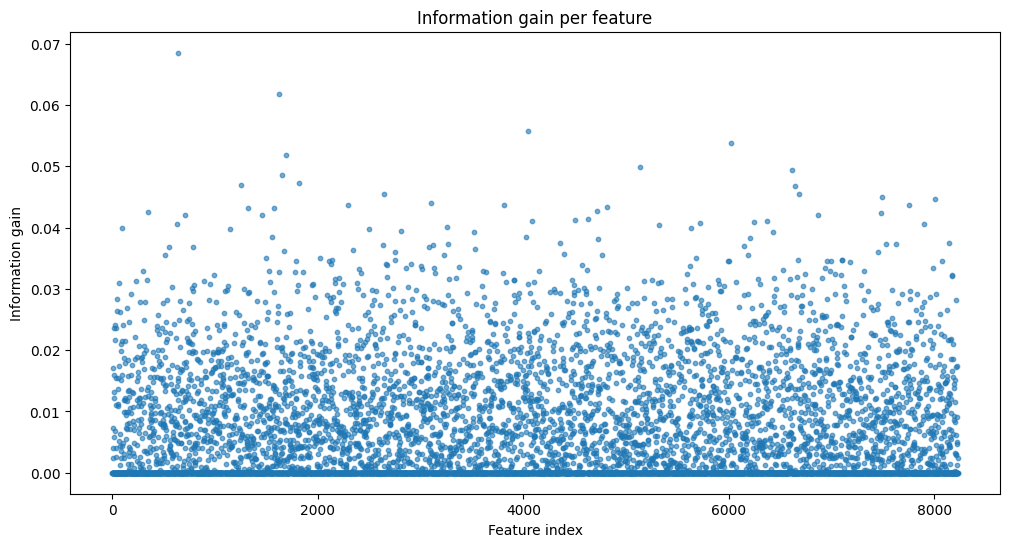

Control time --> 14:40:00



In [6]:
print('=== FEATURE SUBSET SELECTION ===')
print('=== 1. BoW ===')
print(f'Calculating the information gain of each feature...')
ig_scores = mutual_info_classif(X_train_bow, train_labels, random_state=42)
ig_series = pd.Series(ig_scores, index=vocab_bow).sort_values(ascending=False)
print(f'Plotting the results...\n')
plt.figure(figsize=(12, 6))
plt.scatter(range(len(ig_scores)), ig_scores, s=10, alpha=0.6)
plt.title("Information gain per feature")
plt.xlabel("Feature index")
plt.ylabel("Information gain")
plt.show()
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

In [7]:
print('\n=== BEST CONFIGURATION ===')
print(f'Calculating the best algorithm and configuration for BoW...')
percentiles_list = [50, 55, 60, 65, 70]
topK_values = [1000, 2000, 3000, 5000, 8000]
cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)
dev_texts, dev_labels = corpus_builder(dev_pos_lemma, dev_neg_lemma)
results = []

# Percentiles
for element in percentiles_list:
    thresh = np.percentile(ig_scores, element)
    mask = ig_scores >= thresh
    X_sel = X_train_bow[:, mask]

# --- Naive Bayes ---
    NB = MultinomialNB(alpha=0.5)
    cv_scores = cross_val_score(NB, X_sel, train_labels, cv = cv)
    NB.fit(X_sel, train_labels)
    X_dev_sel = bow_vectorizer.transform(dev_texts).toarray()[:, mask]
    dev_acc = NB.score(X_dev_sel, dev_labels)
    results.append({'model':'NB',
                    'method':'percentile',
                    'param':element,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores.mean(),
                    'dev_acc':dev_acc})

# --- Decission tree ---
    DT = DecisionTreeClassifier(criterion='entropy', random_state=42)
    cv_scores_dt = cross_val_score(DT, X_sel, train_labels, cv=cv)
    DT.fit(X_sel, train_labels)
    dev_acc_dt = DT.score(X_dev_sel, dev_labels)
    results.append({'model':'DT',
                    'method':'percentile',
                    'param':element,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores_dt.mean(),
                    'dev_acc':dev_acc_dt})

# --- KNN ---
    KNN = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    cv_scores_knn = cross_val_score(KNN, X_sel, train_labels, cv=cv)
    KNN.fit(X_sel, train_labels)
    dev_acc_knn = KNN.score(X_dev_sel, dev_labels)
    results.append({'model':'KNN',
                    'method':'percentile',
                    'param':element,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores_knn.mean(),
                    'dev_acc':dev_acc_knn})

# --- Random forest ---
    RF = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)
    cv_scores_rf = cross_val_score(RF, X_sel, train_labels, cv=cv)
    RF.fit(X_sel, train_labels)
    dev_acc_rf = RF.score(X_dev_sel, dev_labels)
    results.append({'model':'DT',
                    'method':'percentile',
                    'param':element,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores_rf.mean(),
                    'dev_acc':dev_acc_rf})

# TOP-K
for K in topK_values:
    selector = SelectKBest(score_func=chi2, k=min(K, X_train_bow.shape[1]))
    X_sel = selector.fit_transform(X_train_bow, train_labels)

# --- Naive Bayes ---
    NB = MultinomialNB(alpha=0.5)
    cv_scores = cross_val_score(NB, X_sel, train_labels, cv=cv)
    NB.fit(X_sel, train_labels)
    X_dev_sel = selector.transform(bow_vectorizer.transform(dev_texts))
    dev_pred_nb = NB.predict(X_dev_sel)
    dev_acc = NB.score(X_dev_sel, dev_labels)
    results.append({'model':'NB',
                    'method':'top-K',
                    'param':K,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores.mean(),
                    'dev_acc':dev_acc})

# --- Decission tree ---
    DT = DecisionTreeClassifier(criterion='entropy', random_state=42)
    cv_scores_dt = cross_val_score(DT, X_sel, train_labels, cv=cv)
    DT.fit(X_sel, train_labels)
    dev_acc_dt = DT.score(X_dev_sel, dev_labels)
    results.append({'model':'DT',
                    'method':'top-K',
                    'param':K,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores_dt.mean(),
                    'dev_acc':dev_acc_dt})

# --- KNN ---
    KNN = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    cv_scores_knn = cross_val_score(KNN, X_sel, train_labels, cv=cv)
    KNN.fit(X_sel, train_labels)
    dev_acc_knn = KNN.score(X_dev_sel, dev_labels)
    results.append({'model':'KNN',
                    'method':'top-K',
                    'param':K,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores_knn.mean(),
                    'dev_acc':dev_acc_knn})

# --- Random forest ---
    RF = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)
    cv_scores_rf = cross_val_score(RF, X_sel, train_labels, cv=cv)
    RF.fit(X_sel, train_labels)
    dev_acc_rf = RF.score(X_dev_sel, dev_labels)
    results.append({'model':'RF',
                    'method':'top-K',
                    'param':K,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores_rf.mean(),
                    'dev_acc':dev_acc_rf})

results_df_bow = pd.DataFrame(results).sort_values('dev_acc', ascending=False).reset_index(drop=True)
print(f'Best configurations calculated!')
print(f'Results sorted by dev accuracy:\n')
print(results_df_bow.to_string(index=False))

print('\nBest configuration for BoW:')
print(results_df_bow.iloc[0])
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')



=== BEST CONFIGURATION ===
Calculating the best algorithm and configuration for BoW...
Best configurations calculated!
Results sorted by dev accuracy:

model     method  param  n_features  cv_mean  dev_acc
   NB      top-K   8000        8000 0.806667   0.8300
   NB      top-K   5000        5000 0.865000   0.8175
   NB      top-K   3000        3000 0.894167   0.8150
   RF      top-K   1000        1000 0.841667   0.8150
   RF      top-K   8000        8000 0.801667   0.8150
   RF      top-K   3000        3000 0.815000   0.8125
   NB percentile     50        4115 0.821667   0.8075
   RF      top-K   5000        5000 0.807500   0.8050
   NB percentile     55        3703 0.811667   0.8000
   NB      top-K   2000        2000 0.890000   0.8000
   RF      top-K   2000        2000 0.827500   0.7875
   NB      top-K   1000        1000 0.879167   0.7875
   DT percentile     65        2880 0.795833   0.7775
   NB percentile     60        3292 0.808333   0.7750
   DT percentile     50        4115 0

Generating classification reports and confussion matrix...

=== Metrics for DT (percentile=65) ===
Confusion matrix:
[[119  65]
 [ 78 138]]

Classification report:
              precision    recall  f1-score   support

    negative       0.60      0.65      0.62       184
    positive       0.68      0.64      0.66       216

    accuracy                           0.64       400
   macro avg       0.64      0.64      0.64       400
weighted avg       0.64      0.64      0.64       400


=== Metrics for KNN (top-K=5000) ===
Confusion matrix:
[[169  15]
 [142  74]]

Classification report:
              precision    recall  f1-score   support

    negative       0.54      0.92      0.68       184
    positive       0.83      0.34      0.49       216

    accuracy                           0.61       400
   macro avg       0.69      0.63      0.58       400
weighted avg       0.70      0.61      0.58       400


=== Metrics for NB (top-K=8000) ===
Confusion matrix:
[[155  29]
 [ 39 177]]



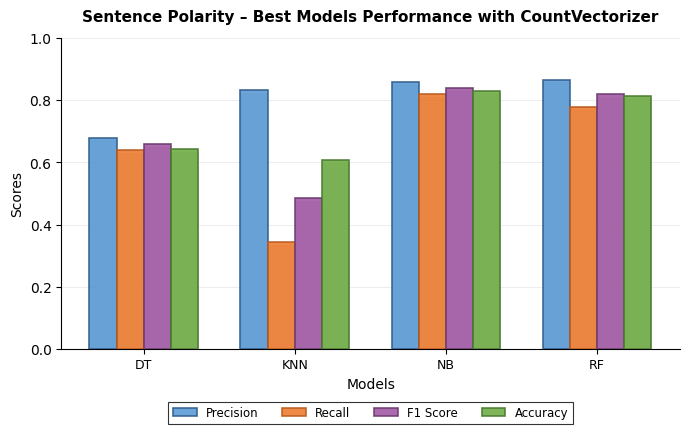

Control time --> 14:41:43



In [8]:
print('Generating classification reports and confussion matrix...')
metrics_df_bow = evaluate_best_models(results_df_bow, X_train_bow, train_labels, dev_texts, dev_labels, bow_vectorizer, ig_scores)
print(metrics_df_bow,'\n')
print('Plotting the metrics...\n')
metrics_bar_chart_bow = plot_metrics_bar_chart(metrics_df_bow, title="Sentence Polarity – Best Models Performance with CountVectorizer")
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

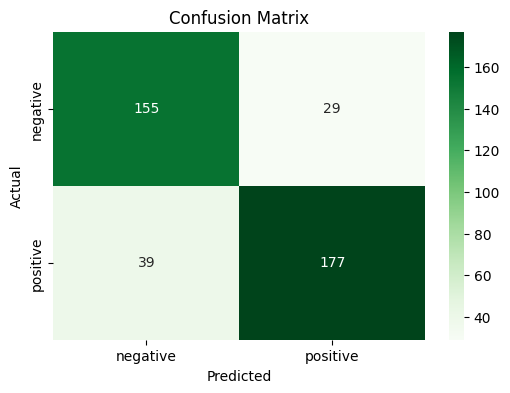

In [9]:

#CM best model
cm = confusion_matrix(dev_labels, dev_pred_nb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=NB.classes_, yticklabels=NB.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [10]:
best = results_df_bow.iloc[0]

if best['method'] == 'top-K':
    selector = SelectKBest(score_func=chi2, k=int(best['param']))
    X_train_selected_bow = selector.fit_transform(X_train_bow, train_labels)
    selected_features_bow = vocab_bow[selector.get_support()]

else:  # percentile
    mask = ig_scores >= np.percentile(ig_scores, best['param'])
    X_train_selected_bow = X_train_bow[:, mask]
    selected_features_bow = vocab_bow[mask]

print(f'Top selected features for BoW according to Information Gain: {len(selected_features_bow)}')
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

Top selected features for BoW according to Information Gain: 8000
Control time --> 14:41:44



# 3.3.2 - TF-IDF

=== FEATURE SUBSET SELECTION ===
=== 2. TF-IDF ===
Calculating the information gain of each feature...
Plotting the results...



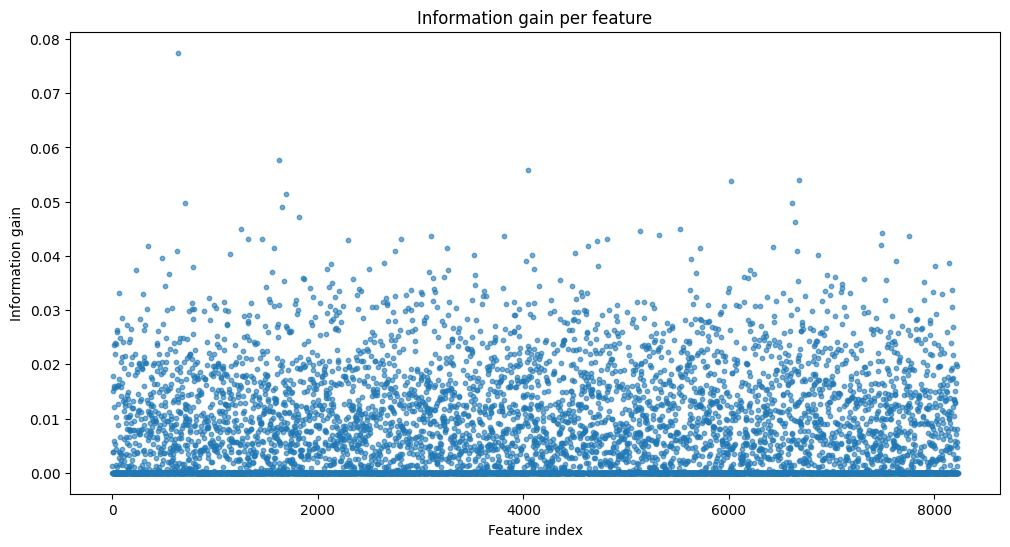

Control time --> 14:42:40



In [11]:
print('=== FEATURE SUBSET SELECTION ===')
print('=== 2. TF-IDF ===')
print(f'Calculating the information gain of each feature...')
ig_scores = mutual_info_classif(X_train_tfidf, train_labels, random_state=42)
ig_series = pd.Series(ig_scores, index=vocab_tfidf).sort_values(ascending=False)
print(f'Plotting the results...\n')
plt.figure(figsize=(12, 6))
plt.scatter(range(len(ig_scores)), ig_scores, s=10, alpha=0.6)
plt.title("Information gain per feature")
plt.xlabel("Feature index")
plt.ylabel("Information gain")
plt.show()
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')


In [12]:
print(f'Calculating the best algorithm and configuration for TF-IDF...')
percentiles_list = [50, 55, 60, 65, 70]
topK_values = [1000, 2000, 3000, 5000, 8000]
cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)
dev_texts, dev_labels = corpus_builder(dev_pos_lemma, dev_neg_lemma)
results = []

# PERCENTILES
for element in percentiles_list:
    thresh = np.percentile(ig_scores, element)
    mask = ig_scores >= thresh
    X_sel = X_train_tfidf[:, mask]

# --- Naive Bayes ---
    NB = MultinomialNB(alpha=0.5)
    cv_scores = cross_val_score(NB, X_sel, train_labels, cv = cv)
    NB.fit(X_sel, train_labels) #<--- better with sparse
    X_dev_sel = tfidf_vectorizer.transform(dev_texts).toarray()[:, mask]
    dev_acc = NB.score(X_dev_sel, dev_labels)
    results.append({'model':'NB',
                    'method':'percentile',
                    'param':element,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores.mean(),
                    'dev_acc':dev_acc})

# --- Decission tree ---
    DT = DecisionTreeClassifier(criterion='entropy', random_state=42)
    cv_scores_dt = cross_val_score(DT, X_sel, train_labels, cv=cv)
    DT.fit(X_sel, train_labels)
    dev_acc_dt = DT.score(X_dev_sel, dev_labels)
    results.append({'model':'DT',
                    'method':'percentile',
                    'param':element,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores_dt.mean(),
                    'dev_acc':dev_acc_dt})

# --- KNN ---
    KNN = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    cv_scores_knn = cross_val_score(KNN, X_sel, train_labels, cv=cv)
    KNN.fit(X_sel, train_labels)
    dev_acc_knn = KNN.score(X_dev_sel, dev_labels)
    results.append({'model':'KNN',
                    'method':'percentile',
                    'param':element,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores_knn.mean(),
                    'dev_acc':dev_acc_knn})

# --- Random forest ---
    RF = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)
    cv_scores_rf = cross_val_score(RF, X_sel, train_labels, cv=cv)
    RF.fit(X_sel, train_labels)
    dev_acc_rf = RF.score(X_dev_sel, dev_labels)
    results.append({'model':'DT',
                    'method':'percentile',
                    'param':element,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores_rf.mean(),
                    'dev_acc':dev_acc_rf})

#TOP-K
for K in topK_values:
    selector = SelectKBest(score_func=chi2, k=min(K, X_train_tfidf.shape[1]))
    X_sel = selector.fit_transform(X_train_tfidf, train_labels)

# --- Naive Bayes ---
    NB = MultinomialNB(alpha=0.5)
    cv_scores = cross_val_score(NB, X_sel, train_labels, cv=cv)
    NB.fit(X_sel, train_labels)
    X_dev_sel = selector.transform(tfidf_vectorizer.transform(dev_texts))
    dev_acc = NB.score(X_dev_sel, dev_labels)
    results.append({'model':'NB',
                    'method':'top-K',
                    'param':K,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores.mean(),
                    'dev_acc':dev_acc})

# --- Decission tree ---
    DT = DecisionTreeClassifier(criterion='entropy', random_state=42)
    cv_scores_dt = cross_val_score(DT, X_sel, train_labels, cv=cv)
    DT.fit(X_sel, train_labels)
    dev_acc_dt = DT.score(X_dev_sel, dev_labels)
    results.append({'model':'DT',
                    'method':'top-K',
                    'param':K,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores_dt.mean(),
                    'dev_acc':dev_acc_dt})

# --- KNN ---
    KNN = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    cv_scores_knn = cross_val_score(KNN, X_sel, train_labels, cv=cv)
    KNN.fit(X_sel, train_labels)
    dev_acc_knn = KNN.score(X_dev_sel, dev_labels)
    results.append({'model':'KNN',
                    'method':'top-K',
                    'param':K,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores_knn.mean(),
                    'dev_acc':dev_acc_knn})

# --- Random forest ---
    RF = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)
    cv_scores_rf = cross_val_score(RF, X_sel, train_labels, cv=cv)
    RF.fit(X_sel, train_labels)
    dev_acc_rf = RF.score(X_dev_sel, dev_labels)
    results.append({'model':'RF',
                    'method':'top-K',
                    'param':K,
                    'n_features':X_sel.shape[1],
                    'cv_mean':cv_scores_rf.mean(),
                    'dev_acc':dev_acc_rf})

print(f'Best configurations calculated!')
print(f'Results sorted by dev accuracy:\n')
results_df_tfidf = pd.DataFrame(results).sort_values('dev_acc', ascending=False).reset_index(drop=True)
print(results_df_tfidf.to_string(index=False))

print('\nBest configuration for TF-IDF:')
print(results_df_tfidf.iloc[0])
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

Calculating the best algorithm and configuration for TF-IDF...
Best configurations calculated!
Results sorted by dev accuracy:

model     method  param  n_features  cv_mean  dev_acc
   RF      top-K   3000        3000 0.823333   0.8150
   NB      top-K   2000        2000 0.903333   0.8125
   NB      top-K   3000        3000 0.892500   0.8100
   NB      top-K   5000        5000 0.866667   0.8075
   NB      top-K   8000        8000 0.798333   0.8050
   RF      top-K   1000        1000 0.834167   0.7950
   NB      top-K   1000        1000 0.902500   0.7900
   DT percentile     50        4115 0.765833   0.7850
   NB percentile     55        3703 0.799167   0.7825
   RF      top-K   2000        2000 0.834167   0.7825
   NB percentile     60        3292 0.800833   0.7800
   NB percentile     50        4115 0.796667   0.7800
   DT percentile     60        3292 0.781667   0.7775
   DT percentile     70        2469 0.792500   0.7750
   RF      top-K   5000        5000 0.821667   0.7750
   NB pe

Generating classification reports and confussion matrix...

=== Metrics for DT (percentile=50) ===
Confusion matrix:
[[111  73]
 [ 86 130]]

Classification report:
              precision    recall  f1-score   support

    negative       0.56      0.60      0.58       184
    positive       0.64      0.60      0.62       216

    accuracy                           0.60       400
   macro avg       0.60      0.60      0.60       400
weighted avg       0.61      0.60      0.60       400


=== Metrics for KNN (top-K=8000) ===
Confusion matrix:
[[134  50]
 [ 86 130]]

Classification report:
              precision    recall  f1-score   support

    negative       0.61      0.73      0.66       184
    positive       0.72      0.60      0.66       216

    accuracy                           0.66       400
   macro avg       0.67      0.67      0.66       400
weighted avg       0.67      0.66      0.66       400


=== Metrics for NB (top-K=2000) ===
Confusion matrix:
[[152  32]
 [ 43 173]]



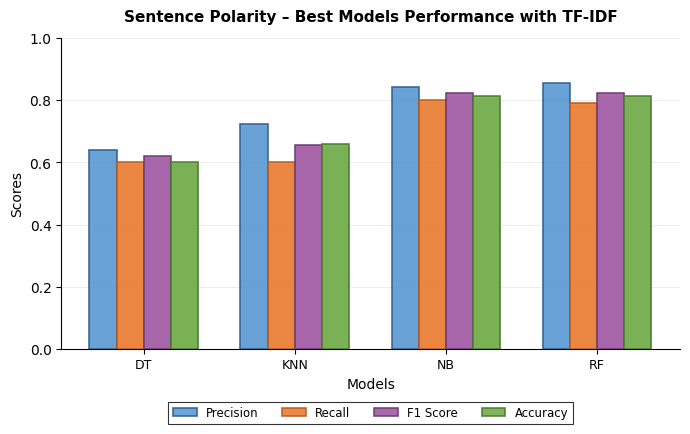

Control time --> 14:44:43



In [13]:
print('Generating classification reports and confussion matrix...')
metrics_df_tfidf = evaluate_best_models(results_df_tfidf, X_train_tfidf, train_labels, dev_texts, dev_labels, tfidf_vectorizer, ig_scores)
print(metrics_df_tfidf,'\n')
print('Plotting the metrics...\n')
metrics_bar_chart_tfidf = plot_metrics_bar_chart(metrics_df_tfidf, title="Sentence Polarity – Best Models Performance with TF-IDF")
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

In [14]:
best = results_df_tfidf.iloc[0]

if best['method'] == 'top-K':
    selector = SelectKBest(score_func=chi2, k=int(best['param']))
    X_train_selected_tfidf = selector.fit_transform(X_train_tfidf, train_labels)
    selected_features_tfidf = vocab_tfidf[selector.get_support()]

else:  # percentile
    mask = ig_scores >= np.percentile(ig_scores, best['param'])
    X_train_selected_tfidf = X_train_tfidf[:, mask]
    selected_features_tfidf = vocab_tfidf[mask]

print(f'Top selected features for TF-IDF according to Information Gain: {len(selected_features_tfidf)}')
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

Top selected features for TF-IDF according to Information Gain: 3000
Control time --> 14:44:43



In [15]:
# Reviews not classified correctly
misclassified_idx = [i for i, (true, pred) in enumerate(zip(dev_labels, dev_pred_nb)) if true != pred]
print(f"Total error in validation set: {len(misclassified_idx)} / {len(dev_labels)}")


# Most frequent words in those errors
error_words = Counter()
for i in misclassified_idx:
    tokens = dev_texts[i].split()
    error_words.update(tokens)

print("\nTop 20 most frequent words in misclassified reviews in validation set:")
print(error_words.most_common(20))

print("\nExamples of misclassified reviews:")
for i in misclassified_idx[:5]:
    print("\n---")
    print("Text pre-processed:", dev_texts[i])
    print("Real label:", dev_labels[i], "| Predicted label:", dev_pred_nb[i])
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

Total error in validation set: 68 / 400

Top 20 most frequent words in misclassified reviews in validation set:
[('film', 348), ('movie', 262), ('one', 189), ('make', 141), ('get', 135), ('character', 120), ('like', 112), ('go', 108), ('see', 97), ('play', 86), ('would', 84), ('good', 80), ('story', 80), ('come', 76), ('well', 76), ('even', 75), ('give', 74), ('time', 70), ('take', 70), ('also', 69)]

Examples of misclassified reviews:

---
Text pre-processed: could paraphrase michelle pfieffer character dangerous mind say beyond rangoon start fair enough movie like school child give benefit doubt chance succeed like think right combination talent effort wonder mountains move good movie make yeah right child fail film director john boorman late success beyond rangoon hinge believability patricia arquette ed wood true romance busty westerner-in-peril wandering 1988 burma without passport though stomach mild plot contrivance get tough task overlook actress lightweight first scene narrati

# 3.4 - Training

In [16]:
print('=== TRAINING ===')
print(f'Training the NB model withte train and dev corpus...')
text_full_train = train_texts + dev_texts
label_full_train = train_labels + dev_labels
f_vectorizer = CountVectorizer(min_df= 5)
X_full_train = f_vectorizer.fit_transform(text_full_train)
selector = SelectKBest(score_func= chi2, k= 8000)
X_final_selected = selector.fit_transform(X_full_train, label_full_train)

model = MultinomialNB(alpha=0.5)
model.fit(X_final_selected, label_full_train)
print(f'NB model trained!')
print(f'Control time --> {datetime.datetime.now().strftime("%H:%M:%S")}\n')

=== TRAINING ===
Training the NB model withte train and dev corpus...
NB model trained!
Control time --> 14:44:44



# 3.5 - Test

In [17]:
X_test = f_vectorizer.transform(blind_lemma)
X_test_sel = selector.transform(X_test)
label_pred = model.predict(X_test_sel)

print(label_pred)

['positive' 'positive' 'positive' 'negative' 'negative' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'negative'
 'negative' 'positive' 'negative' 'negative' 'negative' 'positive'
 'positive' 'positive' 'positive' 'positive' 'negative' 'negative'
 'negative' 'negative' 'positive' 'positive' 'negative' 'negative'
 'positive' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'positive' 'positive' 'positive' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'positive' 'negative' 'negative' 'positive' 'positive'
 'positive' 'positive' 'positive' 'negative' 'positive' 'positive'
 'negative' 'negative' 'negative' 'negative' 'positive' 'positive'
 'negative' 'negative' 'positive' 'positive' 'negative' 'negative'
 'positive' 'positive' 'positive' 'positive' 'positive' 'negative'
 'positive' 'negative' 'positive' 'positive' 'positive' 'positive'
 'negative' 'negative' 'positive' 'positive' 'positive' 'posit

In [18]:
df_test = pd.DataFrame({
    'text': corpus_blind,
    'predicted_label': label_pred
})
print(df_test)
df_test.to_csv("test_predictions.csv", index=False, encoding="utf-8")

                                                  text predicted_label
0    after the terminally bleak reservoir dogs and ...        positive
1    seen april 16 , 1999 at 10 p . m . at crossgat...        positive
2    three things i learned from " being john malko...        positive
3    plot : two teen couples go to a church party ,...        negative
4    swashbuckling adventure that can be enjoyed by...        negative
..                                                 ...             ...
395  the small-scale film , in limited release , " ...        positive
396  some movies ask you to leave your brain at the...        negative
397  the sweet hereafter could serve as a textbook ...        positive
398  the yet-to-be-released krippendorf's tribe is ...        negative
399   * * * warning - the following review contains...        negative

[400 rows x 2 columns]


In [19]:
files.download("test_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>